<h1 align="center">
<strong><u>Senyals i Sistemes - Pràctica 2</u></strong>
<br/><br/>
Aplicacions de la convolució i la correlació: El Vocoder.<h1/>

# <span style="color:#BB44DD">Objectius</span>

En aquesta pràctica continuarem treballant diversos conceptes ja coneguts dels senyals i els sistemes lineals, com ara l'energia i la potència, la periodicitat i les aplicacions de la correlació. Alhora, també treballarem conceptes nous com ara les __equacions en diferències finites__ (EDF) i el __filtrat__.

Tot això, però, no ho farem només basant-nos en exemples acadèmics, sinó sobre aplicacions concretes com són l'__anàlisi de la veu humana__ i la __síntesi de veu artificial__.

# <span style="color:#BB44DD">Introducció</span>

## Producció de la veu humana

La producció del senyal de veu es realitza mitjançant un flux d'aire expel·lit pels pulmons i que passa a través de les __cordes vocals__, el __tracte vocal__ i, en ocasions, el __tracte nasal__ en paral·lel.

<div align="center">
    <img src="VocalTract.png">
</div>

## El paper de les cordes vocals: <u>Fonemes sonors i fonemes sords</u>

Si durant el pas de l'aire les cordes vocals <span style="color: red;">vibren</span>, produeixen una oclusió intermitent del pas de l'aire i el so resultant és aproximadament periòdic i es denomina __sonor__. Si, contràriament, les cordes vocals no vibren aleshores el so resultant no és periòdic i es denomina __sord__.

Per posar alguns exemples: 

* Els fonemes sonors són totes les vocals i algunes consonants (b, d, g...). Aquests utilitzen generalment els tractes vocal i nasal en paral·lel per produir el so.
* Els fonemes sords són sempre consonants (f, s, p, t, k...)
* Hi ha fonemes sonors (m, n...) que utilitzen exclusivament el tracte nasal ja que el vocal queda obstruït per la llengua o els llavis.

## El paper dels tractes vocal i nasal: <u>Ressonàncies</u>

Mitjançant el moviment de la llengua, els llavis, la mandíbula i els músculs que controlen la zona del coll podem variar la _<span style="color: red;">forma</span>_ de les cavitats que es formen en el tracte vocal (la cavitat nasal és fixa). Això fa que aquestes cavitats __ressonin__ a freqüències diferents, cosa que afecta a la forma del senyal produït i, conseqüentment, determina el fonema que estem emetent.

## Metodologia d'anàlisi i síntesi

Òbviament, la veu humana consta d'una sèrie de fonemes encadenats consecutivament, per la qual cosa de cara a l'anàlisi i la síntesi es divideix  el senyal de veu en una sèrie de __trams__ d'uns 30 milisegons de durada, en els quals se suposa que les característiques del senyal es mantenen aproximadament constants. Sovint també s'agafen els trams consecutius de manera que hi hagi un cert __solapament__ entre ells, cosa que ajuda a que les transicions entre paràmetres siguin més suaus.

De tot l'anterior es dedueix que el problema de sintetitzar veu humana és complex, i l'única manera d'abordar-lo amb èxit és dividir-lo en una sèrie de subtasques més senzilles de resoldre. Això és el que farem a continuació, concretament:

1. Aprendrem a visualitzar el senyal de veu i a familiaritzar-nos amb les formes que adopten els diferents fonemes.
2. Analitzarem un fragment de veu per tal de determinar si és sord o sonor i, en aquest darrer cas, quina és la seva periodicitat i la seva energia.
3. Pel fragment escollit, provarem de sintetitzar el mateix senyal de forma artificial fent ús de la informació recollida al pas anterior.
4. Una vegada hàgim fet tot el procés per un sol fonema, repetirem tots els passos anteriors iterant a través de tots els fonemes d'una frase per tal de sintetitzar-la completa.

---

# <span style="color:#BB44DD">Part A: Lectura, visualització i interpretació del senyal de veu</span>

1. Descarregueu els fitxers auxiliars de la pràctica i ubiqueu-los a la mateixa carpeta on teniu aquest «Notebook» de Jupyter.
2. Executeu els fragments de codi següent, que permeten llegir un fitxer d'àudio del disc, presentar-lo visualment i reproduir-lo dins del Jupyter

En aquest exemple s'utilitza un senyal de veu contingut en el fitxer «Frase.wav», corresponent a un locutor femení que llegeix una frase en llengua castellana d'uns 6 segons de durada. Consisteix en un senyal __monofònic__ i mostrejat a una freqüència de mostratge de $f_m = 8\, \mathrm{kHz}$ i gravat en un fitxer «WAV», on les mostres són nombres enters de 16 bits amb signe (interval [-32768..32767]).

In [1]:
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio
%matplotlib inline
#%matplotlib qt
import matplotlib.pyplot as plt

# Llegim l'àudio del disc. «fm» serà la freqüència de mostratge del senyal
# i «frase» serà el vector que conté les mostres de veu
FITXER_WAV = "Frase.wav"
fm, veu_original = wavfile.read(FITXER_WAV)
# Els valors continguts en el fitxer d'àudio són enters de 16 bits amb signe,
# això els normalitza a l'interval [-1..+1) i els converteix a coma flotant.
veu_original = veu_original / 2**15

# Pintem la forma d'ona. Abans creem un vector de temps adient, 
# tenint en compte que la separació entre mostres és T=1/fm
t = np.arange(len(veu_original)) / fm

# Assignem els resultats de les funcions a la «variable» "_" per evitar que s'imprimeixin per pantalla
plt.rcParams['figure.figsize'] = [10, 4]
fig,ax = plt.subplots()
_ = ax.plot(t,veu_original)
_ = ax.grid()
_ = ax.set_title('Senyal de veu a estudiar')
_ = ax.set_ylabel('Amplitud')
_ = ax.set_xlabel('Temps [s]')  

In [2]:
# Reproduïm la frase
veu_original = veu_original.astype(np.float32)           # Important en sistemes windows si volguéssim gravar l'àudio en un fitxer .WAV
Audio(veu_original, rate=fm, autoplay=False)

Dins del Jupyter, obriu el _notebook_ anomenat «Analitzador» en una altra pestanya __i executeu-lo__. Us ha d'aparèixer una finestra amb un conjunt de gràfiques i controls:

* La gràfica superior mostra el senyal de veu en el seu conjunt, amb una franja de color taronja que ressalta el tram a analitzar
* La gràfica central és un _zoom_ del tram a analitzar.
* La gràfica inferior mostra l'__autocorrelació del tram__, normalitzada per tal que el màxim sigui sempre = 1.
* A baix a l'esquerra hi ha uns botons que permeten seleccionar la «finestra» que s'aplicarà al senyal. L'objectiu de l'enfinestrat s'anirà veient poc a poc i completant en pràctiques posteriors. En aquesta pràctica treballarem amb la finestra de HAMMING i no la tocarem, tot i que podeu escollir-ne una altra per veure momentàniament les diferències.
* A baix a la dreta hi ha una barra de desplaçament mitjançant la qual podem seleccionar un dels trams del senyal de veu per visualitzar-lo i analitzar-lo. Cada tram té una durada de 30 milisegons i pot començar en múltiples de 15 milisegons, de manera que se solapa 15ms amb el tram anterior.
* Finalment, al dessota de la barra de desplaçament veiem informació sobre el senyal, <span style="color:red">__que de moment no és funcional i haureu de completar vosaltres a l'apartat següent__</span>.

<span style="color:red">Podeu canviar el tram actual movent la barra de desplaçament amb el ratolí o bé utilitzant les tecles ⬅ i ➡.</span>

---

# <span style="color:#BB44DD">Part B: Anàlisi matemàtica dels diferents trams</span>

En aquesta segona part l'objectiu és fer els càlculs necessaris _en cadascun dels segments o trams en què dividim la veu_ per tal de determinar alguns paràmetres essencials:

1. __L'energia__ del senyal contingut en el tram de veu
2. Si el senyal correspon a un fonema __sord__ o __sonor__.
3. En cas que el fonema sigui _sonor_, determinar la __freqüència de vibració__ de les cordes vocals.

Tot l'anterior ho farem directament modificant el codi de l'Analitzador que heu utilitzat a l'apartat A.

### __IMPORTANT__: El qüestionari associat en aquest cas __no serirà per puntuar__. El seu objectiu és que serveixi com a comprovació del bon funcionament de l'algorisme que heu d'implementar.

## <span style="color:red">__Qüestió 1__</span> - Identificació dels membres del grup de treball

Primer de tot, obriu el qüestionari de la pràctica i a la pregunta 1 indiqueu els membres que formen el grup de treball.

## <span style="color:red">__Qüestió 2__</span> - Càlcul de l'energia del senyal del tram

__Modifiqueu el codi de la funció `analitza_segment` de l'analitzador__ per tal d'assignar a la variable _E_ el valor de l'energia del tram. Un cop fet, __reinicieu l'analitzador__ i comproveu que l'energia calculada es mostra a la part inferior dreta de la finestra. <span style="color: red;">Aleshores procediu a respondre la pregunta 2 del qüestionari, seleccionant prèviament el tram que us indica l'enunciat.</span>

## <span style="color:red">__Qüestió 3__</span> - Autocorrelació de senyals periòdics

A continuació ens interessarà determinar si el tram de senyal analitzat és __sord__ o __sonor__. Del que s'ha explicat anteriorment es pot inferir que si s'està emetent un fonema __sonor__ les cordes vocals estan __vibrant__ i, per tant, el senyal produït presentarà algun tipus de __periodicitat__. En aquest cas, l'autocorrelació és una eina excel·lent per detectar i mesurar aquestes periodicitats, i a continuació en veiem els motius.

Suposem que $p[n]$ és un pols, i que anomenem $r_{pp}[n]$ a la seva autocorrelació. Suposem que amb aquest pols individual construïm un senyal format per una successió de 3 polsos espaiats $N$ mostres, és a dir,
$$ s[n] = p[n] + p[n-N] + p[n-2N] $$

Executeu el següent codi, que mostra les gràfiques del pols individual, de 3 polsos consecutius i les autocorrelacions d'aquests senyals.

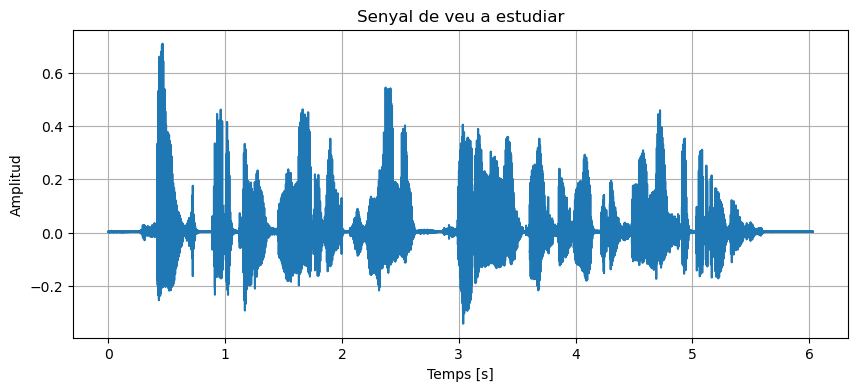

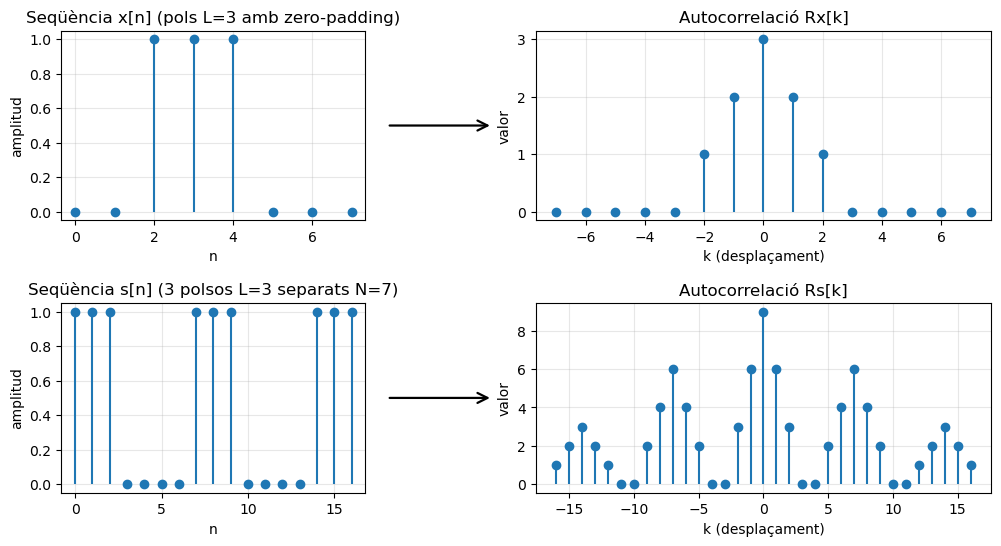

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
from scipy.signal import correlate

# --- Paràmetres ---
L = 3                  # amplada del pols rectangular
pre_pad = 2            # zeros abans del pols dins de x
post_pad = 3           # zeros després del pols dins de x
N = 7                  # separació entre polsos dins de s (N > L)
assert N > L, "Cal N > L per assegurar separació entre polsos"

# --- 1) Seqüència x: pols rectangular amb zero-padding ---
p = np.ones(L, dtype=float)               # pols rectangular bàsic (L mostres)
x = np.r_[np.zeros(pre_pad), p, np.zeros(post_pad)]
n_x = np.arange(len(x))                   # índexs de x

# --- 2) Autocorrelació de x -> Rx ---
Rx_full = correlate(x, x, mode='full')    # correlació (k va de -(M-1) a +(M-1))
lags_x = np.arange(-(len(x)-1), len(x))   # índexs k per a Rx (desfasaments)

# --- 3) Seqüència s: repetició de 3 polsos separats per N mostres ---
#     Construïm una seqüència prou llarga i hi "pintem" els tres polsos p
num_pulsos = 3
len_s = (num_pulsos - 1) * N + L
s = np.zeros(len_s, dtype=float)
for i in range(num_pulsos):
    start = i * N
    s[start:start+L] += p                 # suma (per si mai es volguessin solapar)
n_s = np.arange(len(s))

# --- 4) Autocorrelació de s -> Rs ---
Rs_full = correlate(s, s, mode='full')
lags_s = np.arange(-(len(s)-1), len(s))

# --- 5) Figura 2x2: x, Rx, s, Rs ---
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(3, 3, figure=fig, width_ratios=[1, 0.2, 1.5], height_ratios=[1, 0.15, 1])

ax_x  = fig.add_subplot(gs[0, 0])  # x[n]
ax_Rx = fig.add_subplot(gs[0, 2])  # Rx[k]
ax_s  = fig.add_subplot(gs[2, 0])  # s[n]
ax_Rs = fig.add_subplot(gs[2, 2])  # Rs[k]

# (1,1) x[n]
ax_x.stem(n_x, x, basefmt=" ")
ax_x.set_title("Seqüència x[n] (pols L=3 amb zero-padding)")
ax_x.set_xlabel("n")
ax_x.set_ylabel("amplitud")
ax_x.grid(True, alpha=0.3)

# (1,2) Rx[k]
ax_Rx.stem(lags_x, Rx_full, basefmt=" ")
ax_Rx.set_title("Autocorrelació Rx[k]")
ax_Rx.set_xlabel("k (desplaçament)")
ax_Rx.set_ylabel("valor")
ax_Rx.grid(True, alpha=0.3)

# (2,1) s[n]
ax_s.stem(n_s, s, basefmt=" ")
ax_s.set_title(f"Seqüència s[n] (3 polsos L={L} separats N={N})")
ax_s.set_xlabel("n")
ax_s.set_ylabel("amplitud")
ax_s.grid(True, alpha=0.3)

# (2,2) Rs[k]
ax_Rs.stem(lags_s, Rs_full, basefmt=" ")
ax_Rs.set_title("Autocorrelació Rs[k]")
ax_Rs.set_xlabel("k (desplaçament)")
ax_Rs.set_ylabel("valor")
ax_Rs.grid(True, alpha=0.3)

# Fletxa fila 1: de x[n] -> Rx[k]

# Fletxes entre eixos (ara hi ha un buit al mig)
fig.add_artist(ConnectionPatch(
    xyA=(1.08, 0.5), coordsA=ax_x.transAxes,
    xyB=(-0.1, 0.5), coordsB=ax_Rx.transAxes,
    arrowstyle="->", lw=1.6, mutation_scale=18
))
fig.add_artist(ConnectionPatch(
    xyA=(1.08, 0.5), coordsA=ax_s.transAxes,
    xyB=(-0.1, 0.5), coordsB=ax_Rs.transAxes,
    arrowstyle="->", lw=1.6, mutation_scale=18
))

plt.show()


**Fixeu-vos en la forma de l'autocorrelació $R_s[k]$ d'un senyal amb repeticions o periodicitats.** <span style="color: red;">A partir d'això responeu la pregunta 3 del qüestionari.</span> Clarament --i lògicament-- l'autocorrelació té el màxim a l'origen, però a quin valor de _k_ (desplaçament) es troben els màxims secundaris? Per què?

## <span style="color:red">__Qüestió 4__</span> - Sonoritat

A efectes d'aquesta pràctica considerarem que un tram de senyal és __sonor__ si compleix les següents condicions:

1. Si l'autocorrelació presenta un o més pics locals **diferents del de l'origen**. Tingueu en compte que el màxim d'autocorrelació, $r_{ss}[0]$, s'obté al _centre_ del vector, ja que l'autocorrelació té índexs positius i negatius, simètrics respecte el centre.
2. Que el __més gran__ d'aquests pics locals estigui a una distància __N ≥ a 10 mostres__ del centre i que tingui una amplitud relativa al màxim de l'autocorrelació superior a 0,5, és a dir, $r_{ss}[N]/r_{ss}[0] > 0,\!5$.
3. Si l'energia _E_ del senyal del tram és __superior a 0,3__.

Modifiqueu el codi de la funció `analitza_segment` per tal d'assignar a la variable `maxims` dos vectors que continguin els índexs i valors dels màxims de l'autocorrelació que compleixen les condicions 1) i 2) anteriors. Suggerim utilitzar la funció `find_peaks` del paquet `SciPy.Signal` per tal de cercar els màxims, passant-li els paràmetres adients. 

Fet això, assigneu a la variable `sonor`el valor `True`o `False`.

Reinicieu l'analitzador per tal de verificar que no teniu errors al codi i comproveu que a la part inferior dreta de la finestra es mostra si el tram que escolliu és sonor o no. Aleshores procediu a respondre la pregunta 4 del qüestionari.

## <span style="color:red">__Qüestió 5__</span> - Freqüència de vibració

A la qüestió 3 s'ha vist que l'autocorrelació d'un senyal periòdic de període $N$ mostres presentarà __màxims__ a una distància de $\pm N,\,\pm 2N,\dots$ mostres del centre. Això és així perquè quan desplacem un senyal periódic un nombre de mostres igual a la seva periodicitat, el senyal torna a assemblar-se a sí mateix i per tant l'autocorrelació torna a ser màxima.

Aquesta propietat serà útil per a determinar la freqüència de vibració de les cordes vocals, __evidentment només en el cas que estem davant d'un senyal sonor__. A tal efecte:

* __Penseu un algorisme__ que calculi la separació $N$ (en mostres) entre el màxim a l'origen i el següent màxim més gran, descartant els màxims locals de menor amplitud que hi pugui haver entre ells.
* __Convertiu__ aquesta separació en mostres a separació en segons i, d'aquí a freqüència, consignant aquest darrer valor a la variable « _f_ » de la funció `analitza_segment` de l'Analitzador de veu.

Reinicieu l'analitzador per tal de verificar que no teniu errors al codi i comproveu que a la part inferior dreta de la finestra es mostra la freqüència calculada. Aleshores procediu a respondre la pregunta 5 del qüestionari.

---

# <span style="color:#BB44DD">Part C: Síntesi d'un tram de veu</span>

En aquest part l'objectiu és provar de __generar veu de forma artificial__.

Si volem generar veu sintètica que simuli el millor possible la veu real hem d'aconseguir crear un sistema que generi un senyal amb la __mateixa forma__ que el senyal de veu. Evidentment, com que ja hem vist que el senyal de veu canvia de forma tram a tram, caldrà crear un sistema nou per cada tram. Per tal de fer el problema abordable, __primer farem la síntesi per un sol tram de veu__ i després ho estendrem a la resta de trams.

## Model matemàtic de la producció de veu

Un model matemàtic molt simplificat per a emular el sistema de producció de fonemes consisteix considerar el senyal produït pels pulmons i/o les cordes vocals com una excitació $x[n]$, i els tractes vocal i nasal com un sistema lineal o __filtre__ que emula les seves ressonàncies i modifica aquesta excitació per tal d'obtenir el so desitjat, de tal manera que:

1. Modelem el senyal $x[n]$ com un __tren de polsos__ si el so produït és __sonor__, o com a __soroll__ si el so és __sord__.
2. Com hem dit abans, els tractes vocal i nasal els modelem amb un filtre que té en compte les ressonàncies d'aquestes cavitats. Matemàticament això es pot aconseguir amb un filtre de tipus __autoregressiu__ d'ordre $P$, cosa que significa que _la sortida en un instant donat és una combinació del valor actual de l'excitació i dels $P$ valors anteriors de la pròpia sortida_. Matemàticament:
$$y[n] = b\cdot x[n] - \sum_{k=1}^P a_k\cdot y[n-k]$$
L'equació anterior es coneix com una __equació en diferències finites__ (EDF), i és una de les múltiples maneres d'expressar un sistema lineal.

Per tant, per poder produir veu de forma artificial haurem de __determinar els coeficients $a_1, \dots, a_P, b$ del filtre__ i també __escollir adequadament el senyal d'excitació $x[n]$__ segons el fonema que vulguem reproduir.

![image](Síntesi.png)

## Excitació

El tipus d'excitació que hem de posar a l'entrada del filtre dependrà de si el fonema és sonor o sord:

* Si el fonema és __sonor__, generarem una excitació consistent en un __tren de deltes__ d'amplitud $\sqrt{N}$ i separades $N$ mostres, essent $N$ és el període (en mostres) calculat a la qüestió 5.
* Si el fonema és __sord__ usarem com a excitació un generador de soroll de variància 1, per exemple gaussià blanc: `np.random.normal(...)`.

<span style="color:#DD0000;">En tots els casos la longitud de l'excitació serà de __120 mostres__ (15ms).</span>

## <span style="color:red">__Qüestió 6__</span>

Per què creieu que donem una amplitud de $\sqrt{N}$ a l'excitació sonora? Responeu-ho al qüestionari.

## Síntesi per filtrat (sistema lineal)

L'anàlisi de la veu hauria d'incloure el càlcul dels coeficients $b$ i $a_k$ de l'equació en diferències, però aquesta és una qüestió que ultrapassa els objectius docents del moment. Per aquest motiu, els coeficients del filtre corresponents a cadascun dels trams es proporcionen al fitxer `Coeficients_Frase.npz`, que carregareu tal com es mostra al codi del dessota.

Fet això, haureu de completar el codi següent per tal de:

1. Escollir un tram de veu de 15 ms de durada.
2. Llegir el tram de veu.
3. Generar una excitació x[n] adequada en funció de si el tram escollit és sord o sonor.

La resta de codi ja està programada (no cal que feu res) i consisteix en generar la veu sintetitzada usant l'excitació que heu generat i comparar visualment el resultat amb la veu original.

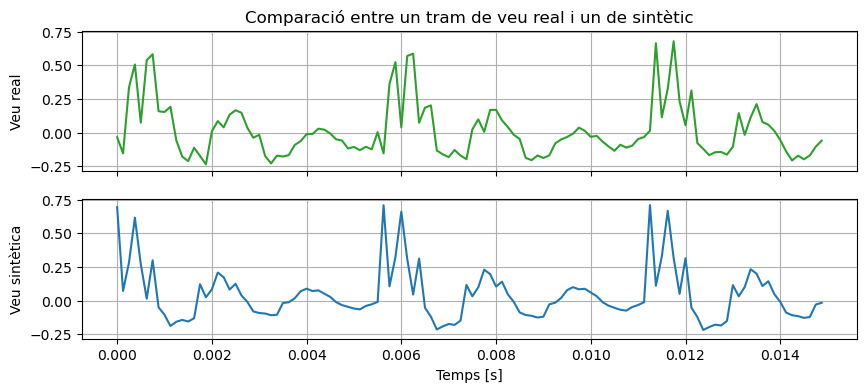

In [4]:
### Carreguem els coeficients del filtre en cada tram.
# Construïm el nom del fitxer de coeficients
base,extensio = FITXER_WAV.split('.', 1)
fitxer_coef = "Coeficients_" + base + '.npz'
# Carreguem amb gestió d'excepcions
with np.load(fitxer_coef) as coef:
    a = coef['a']       # a[k] contindrà els coeficients a1..aP del tram «k»
    b = coef['b']       # b[k] contindrà el coeficient b del tram «k»

# ATENCIÓ: Usarem una longitud del tram de síntesi de 120 mostres (15ms) i no 240 (30ms),
# perquè en l'anàlisi els trams se solapaven 15ms.
Ls = 120

# Completeu el codi per tal de sintetitzar i visualitzar el senyal corresponent al tram de veu que us agradi més
# Com a suggeriment, podeu provar els trams:
#   30, 37, 68, 84, 105, 160, 165 o 242 (sonors) 
#   47, 250, 261, 290, 325, 335 (sords)
num_tram =  30
tram_original = veu_original[120*num_tram - Ls//2 : 120*num_tram + Ls//2]
CORRECCIO = 1.59   # Correcció de la pèrdua d'energia a causa de l'enfinestrat de Hamming

# Decidireu la sonoritat en funció de l'anàlisi del senyal fet anteriorment a la funció «analitza_segment»
sonor = True     # Ha de ser «True» o «False»

if sonor:
    # Genereu l'excitació sonora (tren de deltes d'amplitud sqrt(N)) separades N mostres.
    # «f» és la freqüència fonamental del senyal obtinguda en l'analitzador de trams.
    f = 177.78                     # <<<<< completeu
    N =  45                    # <<<<< completeu
    x = np.arange(Ls)
    x = CORRECCIO * np.sqrt(N) * ((x % N) == 0).astype(float)
else:
    # Genereu l'excitació sorda
    x = CORRECCIO * np.random.normal(0.0, 1.0, Ls)      # <<<<< completeu

# Finalment fem passar l'excitació a través del filtre per tal d'obtenir la veu sintetitzada
# Això ho farem amb la funció «lfilter», que treballarem més en pràctiques posteriors
from scipy.signal import lfilter
tram_sintetitzat = lfilter(b[num_tram], a[num_tram], x)

# Presenteu en un gràfic el tram de veu original i el sintetitzat, per tal de poder-los comparar
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, sharey=True)
t = np.arange(Ls)/fm
_ = ax1.plot(t,tram_original, color='C2')
_ = ax1.grid(True, which='both', axis='both')
_ = ax1.set_title('Comparació entre un tram de veu real i un de sintètic')
_ = ax1.set_ylabel('Veu real')

_ = ax2.plot(t,tram_sintetitzat)
_ = ax2.grid(True, which='both', axis='both')
_ = ax2.set_ylabel('Veu sintètica')
_ = ax2.set_xlabel('Temps [s]')

plt.show()

# <span style="color:#BB44DD">Part D: Síntesi de la frase completa</span>

La frase completa la sintetitzarem generant artificialment cadascun dels trams del senyal de veu i concatenant-los tots procurant que les transicions no presentin salts bruscs i siguin el més suaus possible.

## Objectius

A les parts prèvies (A, B, C) hem vist com analitzar __un tram de veu__ per tal d'extreure'n diferents característiques i paràmetres que el defineixen:

- L'energia del tram
- Si el senyal del tram correspon a un fonema sord o sonor
- En cas de sonoritat, la freqüència fonamental del senyal.

També hem vist com podem __sintetitzar__ un senyal semblant a l'analitzat, aplicant una excitació adient a l'entrada d'un sistema lineal que simula les ressonàncies que es produeixen a l'aparell fonador.

A continuació el que es pretén és estendre allò que s'ha fet per un sol tram de veu a tots els trams de veu d'una frase, concatenant els diferents senyals sintetitzats __de manera que les transicions entre trams siguin el més suaus possible__, tal com passa en la veu humana.

## Algorisme

Per tal d'aconseguir els objectius fixats haureu d'escriure un petit programa en Python usant la plantilla i fragments de codi que trobareu a continuació. Dividirem la tasca en les parts següents, que són més curtes i simples d'abordar:

 0. «Imports» i definició de constants i funcions auxiliars
 1. Càrrega del fitxer d'audio
 2. Càlcul de quants trams solapats caben en l'àudio carregat
 3. Bucle d'anàlisi dels trams i recopilació d'informació
 4. Bucle de síntesi de l'àudio (vocoder)
 5. Presentació gràfica de resultats

## Part D-0: _Imports_ i definicions.

La majoria d'aquest codi ja s'ha posat anteriorment, però el repetim aquí per assegurar-nos que aquesta part "D" és autocontinguda.

In [5]:
# D-0. Imports i definició de constants

from os.path import split, join
import numpy as np
from scipy.signal import correlate, find_peaks, lfilter, lfilter_zi
from scipy.signal.windows import hamming
from scipy.io import wavfile
from IPython.display import Audio
%matplotlib inline
#%matplotlib ipympl
#%matplotlib qt
import matplotlib.pyplot as plt
# Fem la mida per defecte dels plots una mica més gran
plt.rcParams["figure.figsize"] = [14, 10]
plt.rcParams["figure.dpi"] = 80

FITXER_WAV = "Frase.wav"

## Part D-1: Definició de variables d'anàlisi/síntesi i funcions auxiliars.

En el codi següent, completeu la funció `analitza_tram` per tal que calculi l'energia, sonoritat i freqüència fonamental del senyal (en cas que sigui sonor). El codi és essencialment el mateix que heu hagut de'escriure a l'estudi previ, però __amb una diferència__: <span style="color:red">noteu que aquí no es demana de retornar el valor de la freqüència fonamental del senyal en Hz, sinó la separació __en mostres__ entre els dos màxims més alts de l'autocorrelació</span>. Fem aquesta variació perquè d'aquesta manera serà més senzill unir tots els trams, com veurem més endavant.

In [6]:
# D-1. Definició de variables i funcions auxiliars

# Paràmetres de l'anàlisi
fm = 8000
DURADA_T     = 30E-3        # Longitud dels trams de veu, en segons
SOLAPAMENT_T = 15E-3        # Longitud dels solapaments, en segons
FREQ_BASE_MAX = 220         # Màxima freq. fonamental dels formants, per evitar falses deteccions
SEP_MIN = fm/FREQ_BASE_MAX  # Traduïm l'anterior a separació entre mostres
E_MIN_SONOR = 0.1           # Energia mínima per considerar sonor un tram
ALÇADA_MIN_PIC = 0.4        # Alçada relativa mínima dels pics de l'autocorrelació per detectar periodicitats
CORRECCIO = 1.59            # Factor de correcció per compensar la pèrdua d'amplitud (volum) causada per l'enfinestrat


def analitza_tram(tram):
    """
    Funció que analitza un tram i n'extreu diferents característiques.
    
    Paràmetres: 
        tram: El fragment de veu a analitzar (np.array) (ja enfinestrat)
    
    Retorna: 
        E:     L'energia del senyal contingut al tram (nombre en coma flotant)
        sonor: La sonoritat del tram (booleà True/False)
        sep:   Si el tram és SONOR, la separació, EN MOSTRES, entre el màxim de l'autocorrelació i el següent pic més gran.
               En cas que el tram sigui SORD, sep = np.nan
    """
    ## Tots els paràmetres demanats tenen com a base l'autocorrelació
    R = correlate(tram, tram, mode='same', method='direct')

    ## Calculeu l'energia, la sonoritat i la separació entre els dos màxims més grans de l'autocorrelació,
    ## tenint en compte les constants SEP_MIN, E_MIN_SONOR i ALÇADA_MIN_PIC definides amb anterioritat
    R_max = np.max(R)
    R_norm = R / R_max     # Normalitzem

    E = R_max        #  <<<<<<<<<<< Completeu-ho

    indexs_pics, valors_pics = find_peaks(R_norm, distance=SEP_MIN, height = ALÇADA_MIN_PIC)    #  <<<<<<<<<<< Completeu-ho
    maxims = {
        'indexs': np.array(indexs_pics),
        'valors': np.array(valors_pics['peak_heights'])
    }
    
    sonor = len(maxims['indexs']) > 1 and E > E_MIN_SONOR
    maxss = [x if x != 1 else 0 for x in maxims['valors'] ]
    maxind = np.argmax(maxss)
    sep = 120 - maxims['indexs'][maxind] if sonor else np.nan
    f = fm/sep
    
    return E, sonor, sep

## Part D-2: Càlcul del nombre de trams.

Completeu el codi per tal de calcular:

1. Quants trams __solapats__ caben en el fragment de veu.
2. L'excés de mostres que no caben en un nombre enter de trams (aquest nombre l'usarem després per tal de completar la veu sintetitzada i fer que tingui la mateixa longitud que l'original).

L'única dificultat d'aquesta part és que la presència del solapament pot fer que, si no estem atents, en l'extracció del darrer tram ens quedem sense mostres i es generi una excepció.

In [7]:
# D-2. Càlcul de quants trams solapats caben en l'àudio carregat

## Calculeu el valor d'aquestes constants, totes en MOSTRES
# LONG_A:      Longitud de les trames d'anàlisi
# SOLAPAMENT:  Solapament dels trams d'anàlisi, en mostres
# LONG_S:      Longitud de les trames de síntesi
# NUM_TRAMS:   Nombre de trames de síntesi que podem arribar a crear
LONG_A = int(fm*DURADA_T)
SOLAPAMENT = int(fm*SOLAPAMENT_T)
LONG_S = int(fm*15e-3)
NUM_TRAMS = len(veu_original)//LONG_S - 1


## Calculeu el nombre «P» de trams que caben al fragment de veu i també l'excés de mostres (si n'hi ha) que no caben en un nombre enter de trams
## Noteu que la durada dels trams és de 30ms, però se solapen 15ms, de manera que en el càlcul de N heu de vigilar que en el darrer tram no us quedeu sense mostres
P, exces = (len(veu_original) - LONG_A)//(LONG_A - SOLAPAMENT) + 1, len(veu_original) - LONG_S*NUM_TRAMS

print(f'El senyal té {P} trams solapats analitzables, amb un excés de {exces} mostres.')

El senyal té 401 trams solapats analitzables, amb un excés de 120 mostres.


## Part D-3: Cicle d'anàlisi i síntesi de cada tram.

<span style="color: red;">__Aquesta és la part principal de la pràctica__:</span> Es tracta de sintetitzar cada tram de veu usant la informació rellevant sobre el tram __i ajuntar després tots aquests trams pet obtenir la frase sintetitzada sencera__.

## Algorisme:

1. Carreguem la informació dels coeficients dels filtres sintetitzadors.
2. Inicialitzem una llista buida que contindrà la veu sintetitzada de cada tram
3. Per cada tram:
   - Extraiem les mostres del tram corresponent i en restem el seu valor mig
   - Enfinestrem el tram amb una finestra de Hamming (així ens concentrem en la part central i no en els extrems).
   - Extraiem la informació útil del tram (energia, sonoritat, separació entre màxims de l'autocorrelació), usant la funció `analitza_tram`.
   - Generem una excitació apropiada al tipus de tram: tren de deltes si és sonor i sorroll blanc si és sord.
   - Sintetitzem el tram amb el filtre adient i desem el resultat a la llista de trams.
4. Un cop calculats tots els trams, els concatenem per obtenir la frase sintetitzada completa. Ajustem la longitud si cal perquè concordi amb la veu original.


In [8]:
# D-3. Cicle d'anàlisi i síntesi dels trams

# Carreguem la llista de coeficients. Té el mateix nom que el fitxer WAV però amb "Coeficients_" davant i extensió «NPZ»
# Construïm el nom del fitxer de coeficients
cami = "."   
nom = "Frase"
fitxer_coef = join(cami, "Coeficients_" + nom + ".npz")

# Carreguem amb gestió d'excepcions
with np.load(fitxer_coef) as coef:
    a = coef['a']       # a[k] contindrà els coeficients a1..aP del tram «k»
    b = coef['b']       # b[k] contindrà el coeficient b del tram «k»

## Calculem la finestra una única vegada
FINESTRA = hamming(LONG_A)

# Inicialitzem variables
veu_sintetitzada = []           # Anirem afegint aquí els trams
first_delta_pos = 0                        # S'UTILITZA A LA PART D-5, DE MOMENT NO EN FEU CAS
zi = 0*lfilter_zi(b[0], a[0]) #c.i. = 0    # S'UTILITZA A LA PART D-5, DE MOMENT NO EN FEU CAS

for num_tram in range(P):
    ## Extracció del tram
    inici_tram = LONG_S*num_tram  # <<<< Calculeu la mostra inicial del tram
    tram = veu_original[inici_tram:inici_tram + LONG_A]      # <<<< Extraieu el fragment de veu. Ha de tenir una durada de 30ms.
    len(tram)
    ## Abans d'analitzar el tram, restem el (possible) component continu del senyal i l'enfinestrem
    tram = tram - np.mean(tram)
    tram = tram * FINESTRA

    # Calculem paràmetres del tram
    E, sonor, sep = analitza_tram(tram)
    # Generem l'excitació, sorda/sonora segons l'anàlisi, i amb el període adient
    if sonor:
        # protecció contra "sep" massa petits
        if sep < 1:
            sep = 1
        # Creem l'excitació sonora (tren de deltes)
        x = np.arange(LONG_S)
        x = CORRECCIO * np.sqrt(sep) * ((x % sep) == 0)
    else:
        # Genereu l'excitació sorda
        x = CORRECCIO * np.random.normal(0.0, 1.0, LONG_S)
    # Filtrem l'excitació amb el filtre indicat pels coeficients

    y = lfilter(b[num_tram], a[num_tram], x)   # <<<<<<<<<<<<<<<<<<<<<<<<<<<<
    veu_sintetitzada.append(y)
    
# Afegiu al final els zeros necessaris per igualar les longituds de les veus original i sintètica i així poder-les representar conjuntament

veu_sintetitzada.append([0]*exces)  # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<"""

# Concatenem tots els trams de la llista en un únic array NumPy
veu_sintetitzada = np.concatenate(veu_sintetitzada)

## Part D-4: Visualització de resultats i desat a fitxer.

Presentem un gràfic amb la veu original i sintetitzada, per tal de poder-les comparar. També desem la veu sintètica en un fitxer. Ho fem en blocs de codi diferents per tal que una sortida no tapi la segûent.

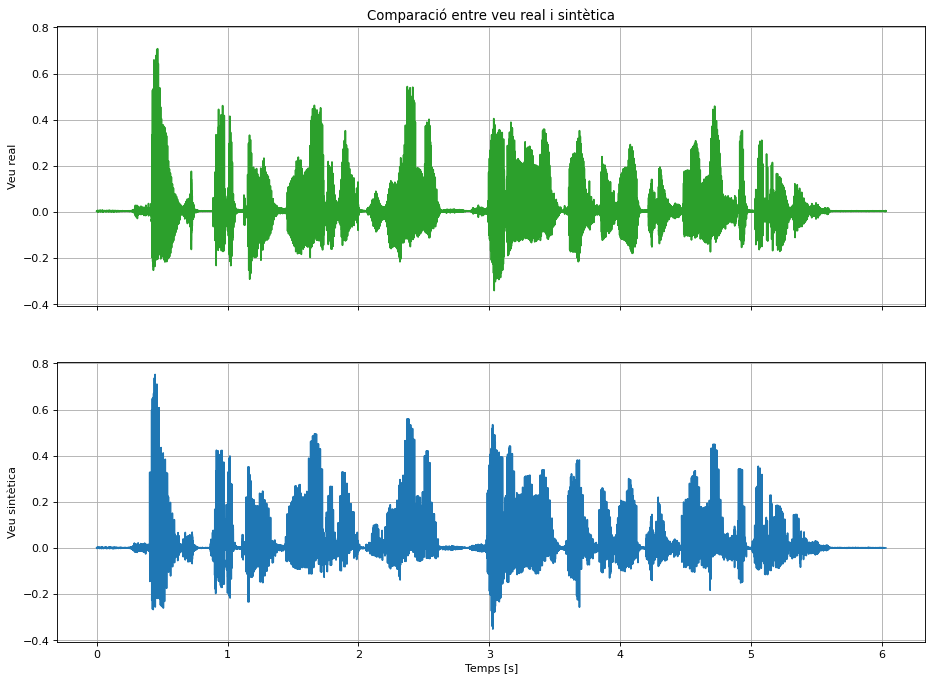

In [9]:
# D-4. Presentació i desat de resultats

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
t = np.arange(len(veu_original)) / fm
_ = ax1.plot(t,veu_original, color='C2')
_ = ax1.grid(True, which='both', axis='both')
_ = ax1.set_title('Comparació entre veu real i sintètica')
_ = ax1.set_ylabel('Veu real')
_ = ax2.plot(t,veu_sintetitzada)
_ = ax2.grid(True, which='both', axis='both')
_ = ax2.set_ylabel('Veu sintètica')
_ = ax2.set_xlabel('Temps [s]')
plt.show()

In [10]:
# Escoltem la veu dins del Jupyter
veu_sintetitzada = veu_sintetitzada.astype(np.float32)    # <<<< Sembla que és important en sistemes Windows
Audio(veu_sintetitzada, rate=fm, autoplay=False)

In [11]:
# Desat de la veu sintetitzada (OPCIONAL)
# Convertim a int16
veu_sintetitzada = veu_sintetitzada * 2**15
veu_sintetitzada = veu_sintetitzada.astype(np.int16)
wavfile.write(join(cami, nom) + '_sintètica.wav', fm, veu_sintetitzada)

## Part D-5: Millora de l'algorisme.

Si escolteu el vostre primer intent de síntesi de veu i observeu atentament el senyal generat (fent el _zoom_ que calgui), veureu que la qualitat del resultat és millorable:

- S'aprecien discontinuïtats en el senyal de veu
- Hi ha intervals de zeros on no hi hauria d'haver senyal.

Les causes d'això són diverses i per aquest motiu la tècnica de la síntesi de la veu no és bufar i fer ampolles. Però hi ha dues millores senzilles que podeu fer al vostre algorisme, que faran augmentar molt la qualitat del resultat:

1. Cada vegada que genereu un tram de veu fent passar la vostra excitació pel filtre, aquest comença amb unes condicions inicials nul·les i per això la sortida és completament independent de la del tram anterior, cosa que fa que es puguin produir "salts" entre trams i/o zones buides de senyal mentre no arriba la primera "delta" de l'excitació del tram següent. Per tal d'evitar o minimitzar això, hem de fer entrar en joc les __condicions inicials i finals__ del filtre.

    Si consulteu l'ajuda de la funció `lfilter` veureu que accepta com a entrada un paràmetre «`zi`» que són les condicions inicials (també anomenades «estat») a l'inici del càlcul, i retorna un paràmetre «`zf`» que són les condicions (estat) al __final__ del càlcul. <span style="color:red">Així, només cal desar l'estat final de cada tram per tal d'usar-lo com a estat inicial del següent tram</span>. El primer estat de tots serà obviament nul i l'inicialitzarem així:
    
    ```zi = 0*lfilter_zi(b[0], a[0]) #c.i. = 0```

2. Per cada trama sonora generem una excitació consistent en un tren de deltes separades «`sep`» mostres. Però si sempre fem que la primera delta de cada tram estigui a la posició zero, pot passar perfectament que la separació entra l'última delta del tram anterior i la primera del nou tram sigui massa petita/gran, cosa que provocarà una primera resposta massa prop/lluny d'on tocaria i això generarà freqüències que no hi haurien de ser.

    En conseqüència, el tren de deltes del nou tram NO ha de començar a la posició zero sinó que ho ha de fer a la posició `sep-Q`, essent _«Q»_ el nombre de mostres entre la darrera delta i el final del tram anterior.
    
### Per tant, l'objectiu d'aquest apartat és fer les modificacions necessàries al codi de la part 4 per tal de millorar el resultat de la síntesi.

In [17]:
# D-5a. Introduïu aquí l'algorisme modificat
# Carreguem la llista de coeficients. Té el mateix nom que el fitxer WAV però amb "Coeficients_" davant i extensió «NPZ»
# Construïm el nom del fitxer de coeficients
cami = "."          # directori actual
nom = "Frase"
fitxer_coef = join(cami, "Coeficients_" + nom + ".npz")

# Carreguem amb gestió d'excepcions
with np.load(fitxer_coef) as coef:
    a = coef['a']       # a[k] contindrà els coeficients a1..aP del tram «k»
    b = coef['b']       # b[k] contindrà el coeficient b del tram «k»

## Calculem la finestra una única vegada
FINESTRA = hamming(LONG_A)

# Inicialitzem variables
veu_sintetitzada = []           # Anirem afegint aquí els trams
first_delta_pos = 0                        # S'UTILITZA A LA PART D-5, DE MOMENT NO EN FEU CAS
zi = 0*lfilter_zi(b[0], a[0]) #c.i. = 0    # S'UTILITZA A LA PART D-5, DE MOMENT NO EN FEU CAS

for num_tram in range(P):
    ## Extracció del tram
    inici_tram = LONG_S*num_tram  # <<<< Calculeu la mostra inicial del tram
    tram = veu_original[inici_tram:inici_tram + LONG_A]      # <<<< Extraieu el fragment de veu. Ha de tenir una durada de 30ms.

    ## Abans d'analitzar el tram, restem el (possible) component continu del senyal i l'enfinestrem
    tram = tram - np.mean(tram)
    tram = tram * FINESTRA

    # Calculem paràmetres del tram
    E, sonor, sep = analitza_tram(tram)
    # Generem l'excitació, sorda/sonora segons l'anàlisi, i amb el període adient
    if sonor:
        # protecció contra "sep" massa petits
        if sep < 1:
            sep = 1
        # Creem l'excitació sonora (tren de deltes)
        x = np.arange(LONG_S)
        x = CORRECCIO * np.sqrt(sep) * (((x-first_delta_pos) % sep) == 0 ) 
        for i in range(1, sep + 1):
            if x[-i] != 0:
                first_delta_pos = sep - i
    else:
        # Genereu l'excitació sorda
        x = CORRECCIO * np.random.normal(0.0, 1.0, LONG_S)
        first_delta_pos = 0
    # Filtrem l'excitació amb el filtre indicat pels coeficients

    y, zi = lfilter(b[num_tram], a[num_tram], x, zi=zi) 
    veu_sintetitzada.append(y)
    
# Afegiu al final els zeros necessaris per igualar les longituds de les veus original i sintètica i així poder-les representar conjuntament

veu_sintetitzada.append([0]*exces)  # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<"""

# Concatenem tots els trams de la llista en un únic array NumPy
veu_sintetitzada = np.concatenate(veu_sintetitzada)


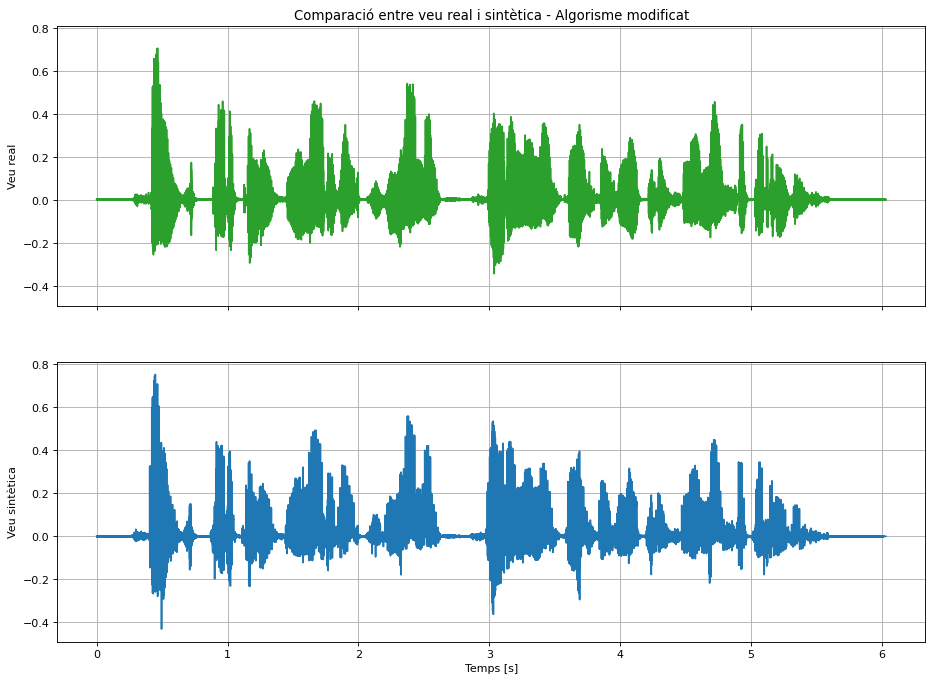

In [18]:
# D-5b. Presentació de resultats

# Plotting
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, sharey=True)
t = np.arange(len(veu_original)) / fm
_ = ax1.plot(t,veu_original, color='C2')
_ = ax1.grid(True, which='both', axis='both')
_ = ax1.set_title('Comparació entre veu real i sintètica - Algorisme modificat')
_ = ax1.set_ylabel('Veu real')
_ = ax2.plot(t,veu_sintetitzada)
_ = ax2.grid(True, which='both', axis='both')
_ = ax2.set_ylabel('Veu sintètica')
_ = ax2.set_xlabel('Temps [s]')
plt.show()
# Escoltem la veu dins del Jupyter
veu_sintetitzada = veu_sintetitzada.astype(np.float32)    # <<<< Sembla que és important en sistemes Windows
Audio(veu_sintetitzada, rate=fm, autoplay=False)

## Part D-6: (OPCIONAL) Modificacions al senyal sintètic.

Com que tenim accés total als paràmetres de síntesi de la veu, podem jugar a variar-ne alguns per tal d'obtenir un senyal sintètic diferent a l'original. Alguns suggeriments que us fem són:

* Podeu «escurçar» o «allargar» la veu modificant la longitud de les trames de síntesi. En aquest cas la veu sintètica tindrà una longitud inferior o superior a la veu original, per la qual cosa haureu d'afegir zeros on correspongui i també recalcular el vector de temps associat, per tal que el codi que genera les gràfiques no es queixi.
* Podeu modificar el període fonamental de cada trama (variable `sep`), per exemple incrementant-lo o decrementant-lo un 20% (i passant-lo a enter) o ser molt més creatiu.
* Podeu considerar tots els trams sords o sonors (en aquest cas mantenint la variable `sep` del tram anterior).

Per cada provatura sintetitzeu el senyal i escolteu el resultat.

__NOTA:__ Si voleu fer aquesta part __no modifiqueu el codi que ja funciona__ (i que heu d'entregar), sinó que copieu al dessota el codi de la part 4 i modifiqueu-lo a banda. Si ho desitgeu i considereu que heu trobat algun efecte interessant podeu generar també la gràfica i incloure el reproductor d'Àudio pel nou senyal.

In [14]:
# (OPCIONAL) Copieu el codi de la part 4 i modifiqueu-lo al vostre gust


In [15]:
# (OPCIONAL) Plotting
#fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, sharey=True)
#t = np.arange(len(veu_original)) / fm
#_ = ax1.plot(t,veu_original, color='C2')
#_ = ax1.grid(True, which='both', axis='both')
#_ = ax1.set_title('Comparació entre veu real i sintètica')
#_ = ax1.set_ylabel('Veu real')
#_ = ax2.plot(t,veu_sintetitzada)
#_ = ax2.grid(True, which='both', axis='both')
#_ = ax2.set_ylabel('Veu sintètica')
#_ = ax2.set_xlabel('Temps [s]')

In [16]:
# (OPCIONAL) Escoltem la veu dins del Jupyter
#veu_sintetitzada = veu_sintetitzada.astype(np.float32)    # <<<< Sembla que és important en sistemes Windows
#Audio(veu_sintetitzada, rate=fm, autoplay=False)

# <span style="color:#BB44DD">Part E: Entrega de resultats.</span>

L'entrega de resultats d'aquesta activitat de laboratori consisteix en aquest mateix «notebook», el qual convertireu prèviament a format HTML seguint els passos següents:

1. A la línia 8 del primer bloc de codi, canvieu `%matplotlib qt` per `%matplotlib inline`.
2. Reinicieu el _kernel_ i executeu tot el full de dalt a baix amb el símbol de la doble fletxa «⏩», comprovant que no teniu cap error al codi.
3. Aneu al menú "file" i __exporteu__ el notebook en format __HTML__.
4. <span style="color: red;">Obriu el fitxer HTML resultant amb un navegador qualsevol i __comproveu que les gràfiques es veuen, que l'àudio se sent i que el codi és el que voleu entregar__.</span>
5. Pugeu el fitxer HTML a la tasca d'ATENEA corresponent. __Entregueu únicament un fitxer per grup de treball__.

----

<h1 align="center">Final de l'enunciat<h1/>

----